In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [ ]:
Pkg.update()
Pkg.instantiate()

In [352]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
include("experiments.jl")

simulation_sweep (generic function with 1 method)

In [361]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 1.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.15
collision_slack = 250.
trust_region_weight = 1.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.3


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.0]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.15
  collision_slack: Float64 250.0
  trust_region_weight: Float64 1.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.3


In [307]:
robot_initial_state = [-10.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [-10.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


# Multi Agent Support

In [230]:
ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(ip.ego_planner.incon, velo_agent_1, velo_agent_2)
add_constant_velocity_agent(ip.other_planner.incon, velo_agent_1, velo_agent_2)

In [231]:
@time ibr(ip, 3, "ego", velo_agent_1, velo_agent_2)

  0.059563 seconds (269.31 k allocations: 24.162 MiB)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


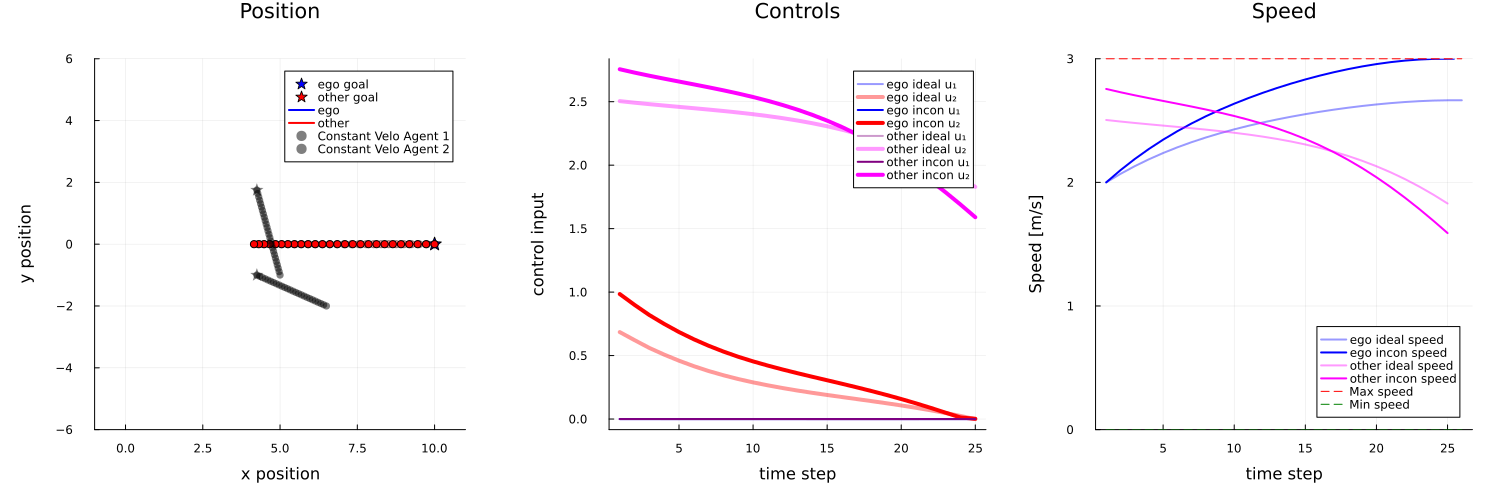

In [232]:
plot_solve_solution(ip, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

In [233]:
value(ip.ego_planner.incon.model[:ϵ])

0.001066463105945573

┌ Info: Saved animation to /tmp/jl_fC7Y5AFCZi.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_fC7Y5AFCZi.gif")
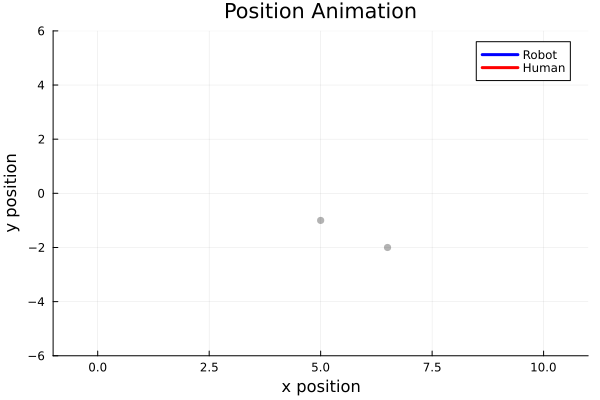

In [234]:
animation(ip, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Simulation Implementation

In [362]:
robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])
velo_agent_3 = ConstantVeloAgent([-5., 2], [0.3, -0.8])

add_constant_velocity_agent(robot_ip.ego_planner.incon, velo_agent_1, velo_agent_2, velo_agent_3)
add_constant_velocity_agent(robot_ip.other_planner.incon, velo_agent_1, velo_agent_2, velo_agent_3)

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(human_ip.ego_planner.incon, velo_agent_1, velo_agent_2, velo_agent_3)
add_constant_velocity_agent(human_ip.other_planner.incon, velo_agent_1, velo_agent_2, velo_agent_3)

In [363]:
robot_params = PlannerParams(robot_ip.ego_planner.incon.hps, robot_ip.ego_planner.incon.opt_params)
human_params = PlannerParams(human_ip.ego_planner.incon.hps, human_ip.ego_planner.incon.opt_params)
sim_params = IPSimParams(robot_params, human_params)

IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.15
  collision_slack: Float64 250.0
  trust_region_weight: Float64 1.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.3
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-1.000000014392981, -2.6562250493873307, -3.651600578761304, -4.103028478682916, -4.208110834229842, -4.1445385417913485, -4.034743323635496, -3.9249414410292047, -3.8151396474657986, -3.705337866

In [364]:
robot_xs, robot_us, human_xs, human_us = simulate(robot_ip, human_ip, 100, velo_agent_1, velo_agent_2, velo_agent_3)

([-10.0 0.0 0.0 2.0; -9.787447262294513 0.0 4.9835561940986443e-8 2.251054754109747; … ; 9.632059057266453 0.08742243370140386 -0.22554333810397525 0.2626809000387912; 9.656740057597352 0.08179799473315 -0.22253704100829877 0.24359435056033235], [4.983556194098644e-7 2.5105475410974676; -0.3446542710309501 -1.5464415299654206; … ; -0.0018519976076877265 -0.1776062491184475; 0.03006297095676472 -0.19086549478458828], [10.0 0.0 3.141592653589793; 9.700000208748303 3.6739378410126466e-17 3.141499314275085; … ; -7.4445849814706495 -0.7714323694806275 2.848387680071248; -7.584718214776766 -0.7291252331005321 2.84839640307098], [-0.0009333931470806337 2.9999979125169682; -0.1177065007915473 2.370789324827202; … ; -7.077882152697738e-5 1.548439811958593; 8.722999731707172e-5 1.4638038415549546])

In [365]:
sim_data = SimData(sim_params, robot_xs, robot_us, human_xs, human_us)

SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.15
  collision_slack: Float64 250.0
  trust_region_weight: Float64 1.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.3
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-37.76725091177883, -36.14189025174085, -34.72604888242586, -33.50308636174907, -32.454641147617906, -31.562360346944615, -30.808907538679875, -30.178405631805788, -29.656595401280583, -29

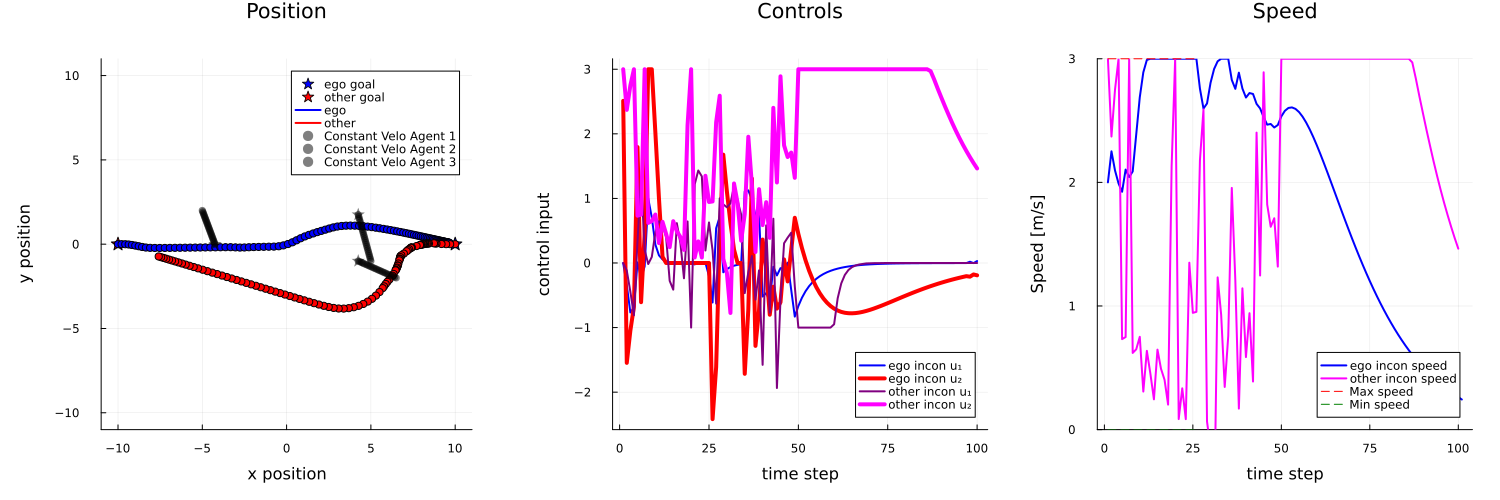

In [366]:
plot_solve_solution(sim_data, velo_agent_1, velo_agent_2, velo_agent_3, pos_xlims=[-11, 11], pos_ylims=[-11, 11])

In [367]:
# bad plotting code but used for animation demonstration

function animation(ego_path::Matrix{Float64}, other_path::Matrix{Float64}, dt::Float64, constant_velo_agents::ConstantVeloAgent...; pos_xlims=[-1, 8], pos_ylims=[-3, 3], save_name="none")
    a = Animation()

    linewidth = 3
    alpha_ideal = 0.2
    ego_color = :blue
    other_color = :red

    markersize=8
    ego_xs = ego_path
    other_xs = other_path

    time_steps = length(ego_path[:, 1])

    N_velo_agents = length(constant_velo_agents)
    constant_velo_agents_pos = Vector{Matrix{Float64}}(undef, N_velo_agents)
    
    for i in 1:N_velo_agents
        pos = constant_velo_agents[i].pos
        velo = constant_velo_agents[i].velo
        constant_velo_agents_pos[i] = vector_of_vectors_to_matrix([pos + velo * dt * j for j in 0:time_steps])
    end

    print(length(constant_velo_agents_pos[1]))

    constant_velo_length = length(constant_velo_agents_pos[1][:, 1])

    plt = plot(xlim=pos_xlims, ylim=pos_ylims, xlabel="x position", ylabel="y position", title="Position Animation", arrow=true, aspect_ration=:equal)


    for i in 1:length(ego_xs[:, 1]) - 1
        plt = plot(ego_xs[1:i,1], ego_xs[1:i,2], color=ego_color, linewidth=linewidth, lab="Robot Path", xlim=pos_xlims, ylim=pos_ylims, xlabel="x position", ylabel="y position", title="Position Animation", margin=10mm, titlefontsize=20, legendfontsize=13, labelfontsize=13, axisfontsize=13)
        plot!(plt, other_xs[1:i,1], other_xs[1:i,2], size=(1200, 800), color=other_color, linewidth=linewidth, lab="Human Path")
        scatter!(plt, ego_xs[i:i, 1], ego_xs[i:i, 2], color=:blue, alpha=0.3, markersize=markersize, label="Robot")
        scatter!(plt, other_xs[i:i, 1], other_xs[i:i, 2], color=:red, alpha=0.3, markersize=markersize, label="Human")

        scatter!(plt, [10000.], [10000.], color=:black, alpha=0.3, markersize=10, label="Non-interactive Humans")

        if i <= constant_velo_length
            for j in 1:N_velo_agents
                scatter!(plt, constant_velo_agents_pos[j][i:i, 1], constant_velo_agents_pos[j][i:i, 2], label="", color=:black, alpha=0.3, markersize=markersize)
            end
        end
        frame(a, plt)
    end

    if save_name != "none"
        gif(a, "../animations/$save_name.gif", fps = 10) 
    end 

    return gif(a, fps=15)
end

animation (generic function with 4 methods)

204

┌ Info: Saved animation to /tmp/jl_F2P6n0hmVs.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_F2P6n0hmVs.gif")
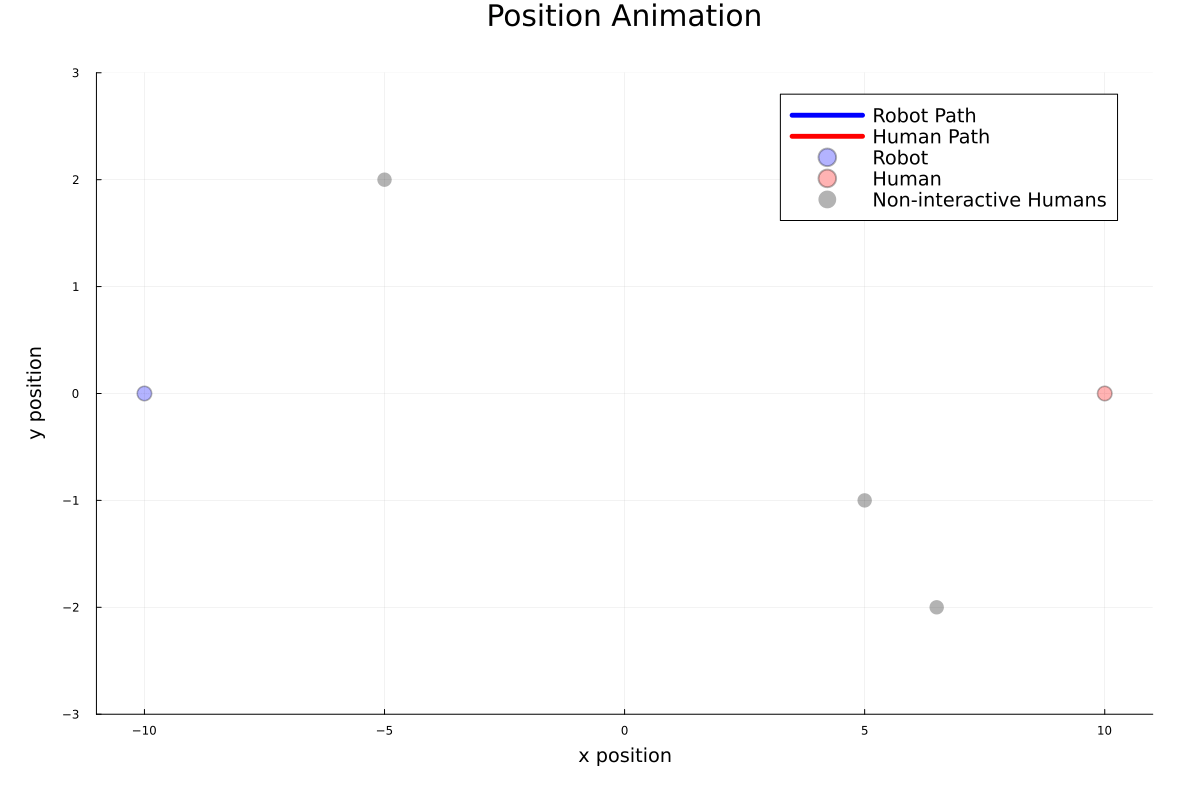

In [368]:
animation(robot_xs, human_xs, 0.1, velo_agent_1, velo_agent_2, velo_agent_3, pos_xlims=[-11, 11])

In [359]:
value(robot_ip.ego_planner.incon.model[:ϵ])

0.0